# Binary Classification Model using Transfer Learning (VGG19).
## Model Building, training and metrics.

I tried to apply [transfer learning methods](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751) (i.e. using pre-trained layers on image classification) to the CNN inspired by similar solutions applied to image classification problems found in Kaggle and Medium.

The input of the network are the two folders of images (Pneumonia versus Normal) and the output is a probability of one or the other using the ['Softmax'](https://en.wikipedia.org/wiki/Softmax_function) activation function. In the following notebook (5_3_Model_Binary_Transfer_Learning) predictions yielded over the test subset of images can be seen. 

##  Imports

### Libraries

In [1]:
# General imports
import numpy as np
import pandas as pd

# System and file management
import os

# Visualization
import matplotlib.pyplot as plt
from imutils import paths

#Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# jupyter:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
# Tensorflow
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

#### Paths

In [4]:
PATH = 'data/' # root
CSV_PATH = os.path.join(PATH,'csv') # folder with csv datasets
DICOM_PATH = os.path.join(PATH, 'pool') # folder containing all of the dicom files
JPG_PATH = os.path.join(PATH, 'pool_jpg') # folder containing all the converted jpg files
DESTINATION_PATH = os.path.join(PATH, 'sorted_balanced') # Folder where the train and test subsets will be located
MODELS_PATH = os.path.join(PATH,'model')

# Train folder
TRAIN_PATH = os.path.join(DESTINATION_PATH, 'train')
TRAIN_NORMAL_PATH = os.path.join(TRAIN_PATH, 'normal')
TRAIN_NNNP_PATH = os.path.join(TRAIN_PATH, 'nnnp')
TRAIN_PNEUMONIA_PATH = os.path.join(TRAIN_PATH, 'pneumonia')

# Validation folder
VAL_PATH = os.path.join(DESTINATION_PATH, 'validation')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'normal')
VAL_NNNP_PATH = os.path.join(VAL_PATH, 'nnnp')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'pneumonia')

# Test folder
TEST_PATH = os.path.join(DESTINATION_PATH, 'test')
TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'normal') 
TEST_NNNP_PATH = os.path.join(TEST_PATH, 'nnnp')
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'pneumonia') 

### Constants

In [5]:
img_width, img_height = 128, 128
NB = 2
BS = 64
EPOCHS = 10

TRAIN_LEN = len(list(paths.list_images(TRAIN_PATH)))
VAL_LEN = len(list(paths.list_images(VAL_PATH)))
TEST_LEN = len(list(paths.list_images(TEST_PATH)))

## Model Building 

### Preprocessing images

In [6]:
trainAug = ImageDataGenerator(rescale = 1./255,
                    fill_mode = "nearest")

valAug = ImageDataGenerator(rescale = 1./255,
                            fill_mode = "nearest")

trainGen = trainAug.flow_from_directory(
                    TRAIN_PATH,
                    target_size = (img_height, img_width),
                    batch_size = BS,
                    shuffle = True,
                    class_mode = "categorical")

valGen = valAug.flow_from_directory(
                    TEST_PATH,
                    target_size = (img_height, img_width),
                    batch_size = BS,
                    shuffle = False,
                    class_mode = "categorical")

testGen = valAug.flow_from_directory(
                    TEST_PATH,
                    target_size = (img_height, img_width),
                    batch_size = BS,
                    shuffle = False,
                    class_mode = "categorical")

Found 8416 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


### Network creation

In [7]:
# Loading pre-trained model (VGG19):
base_model = VGG19(weights = "imagenet", include_top=False, 
                   input_shape = (img_width, img_height, 3))

# Adding layers
x = base_model.output # The output of the pre-trained model is the output of the next layers
x = Flatten()(x) # Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = Dense(1024, activation = "relu")(x) # Create a fully connected layer with ReLU activation and 1024 hidden units
x = Dropout(0.4)(x) # Fully connected layer is followed by a dropout to try to avoid overfitting
x = Dense(256, activation = "relu")(x) # Create a fully connected layer with ReLU activation and 256 hidden units
x = Dropout(0.2)(x) # Fully connected layer is followed by a dropout to try to avoid overfitting.
preds = Dense(NB, activation = "softmax")(x) # Create output layer with two nodes (binary output) and Softmax activation function


# Create model:
# input = Images from the Generator built above
# output = Binary prediction
model = Model(input = base_model.input, output = preds)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Next up, to make sure that the weights of the pre-trained layers (VGG19) don't change through the different steps of the training, we set those layers to non-trainable.

In [8]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

for layer in model.layers[:16]:
    layer.trainable=False
for layer in model.layers[16:]:
    layer.trainable=True

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 flatten_1
23 dense_1
24 dropout_1
25 dense_2
26 dropout_2
27 dense_3


### Summary

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

### Compilation

In [10]:
model.compile(loss = "categorical_crossentropy", 
                    optimizer = SGD(lr=0.001, momentum=0.9), 
                    metrics=["accuracy"])

### Fitting and Saving

The image generator (trainGen) is fitted into the model. Epochs (constant defined above) is set to 10. The validation data is obtained from the validation image generator (valGen) built above. The steps are calculated by diving the total number of files of each subset by the size of the batch (BS = Batch Size)

In [11]:
H = model.fit_generator(
        trainGen,
        epochs = EPOCHS,
        steps_per_epoch = TRAIN_LEN // BS,
        validation_data = valGen,
        validation_steps = VAL_LEN // BS,
        verbose=1)

model.save('4_3_Model_Binary_Transfer_VGG19_7_epochs.h5')


Epoch 1/10
131/131 [==============================] - 63s 478ms/step - loss: 0.3974 - accuracy: 0.8285 - val_loss: 0.1317 - val_accuracy: 0.8956
Epoch 2/10
131/131 [==============================] - 65s 493ms/step - loss: 0.2668 - accuracy: 0.8957 - val_loss: 0.1801 - val_accuracy: 0.9029
Epoch 3/10
131/131 [==============================] - 64s 490ms/step - loss: 0.2410 - accuracy: 0.9067 - val_loss: 0.1758 - val_accuracy: 0.9103
Epoch 4/10
131/131 [==============================] - 65s 494ms/step - loss: 0.2290 - accuracy: 0.9127 - val_loss: 0.0911 - val_accuracy: 0.9069
Epoch 5/10
131/131 [==============================] - 65s 492ms/step - loss: 0.2274 - accuracy: 0.9119 - val_loss: 0.1190 - val_accuracy: 0.8994
Epoch 6/10
131/131 [==============================] - 64s 487ms/step - loss: 0.2016 - accuracy: 0.9247 - val_loss: 0.1463 - val_accuracy: 0.9230
Epoch 7/10
131/131 [==============================] - 63s 482ms/step - loss: 0.1918 - accuracy: 0.9279 - val_loss: 0.4922 - val_a

### Predicting the output and generating performance charts

The model is used to generate predictions over the test subset in order to obtain performance metrics.

#### Accuracy and Classification Report 

In [16]:
testGen.reset()
predictions = model.predict_generator(testGen, steps = (TEST_LEN // BS) + 1) 
predictions = np.argmax(predictions, axis=1)

print("Test set accuracy: " + 
      str(accuracy_score(testGen.classes, predictions, normalize=True) * 100) 
      + "%") 

print(classification_report(testGen.classes, predictions,
                            target_names=testGen.class_indices.keys())) 

Test set accuracy: 92.35033259423503%
             precision    recall  f1-score   support

  pneumonia       0.92      0.93      0.93       920
     normal       0.92      0.92      0.92       884

avg / total       0.92      0.92      0.92      1804



#### Confusion Matrix 

In [17]:
print('Confusion Matrix')
print(confusion_matrix(testGen.classes, predictions))

Confusion Matrix
[[854  66]
 [ 72 812]]


#### Training info over epochs

Next, the performance data of the different epochs is generated, for clarifying reasons.

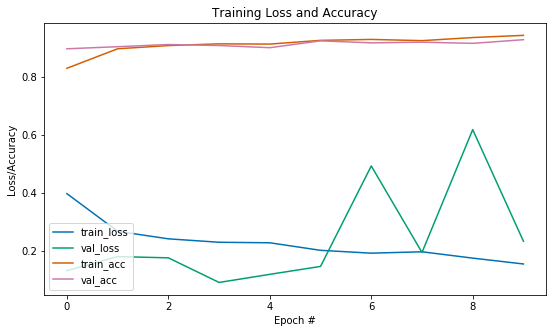

In [21]:
# plotting training data
plt.style.use("seaborn-colorblind")
plt.figure(figsize=(9,5))
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Model_Binary_Transfer_Learning_VGG19_10_epochs.jpg")

#### ROC Curve 

In [19]:
fpr, tpr, thresholds = roc_curve(testGen.classes, predictions)
auc = auc(fpr, tpr)

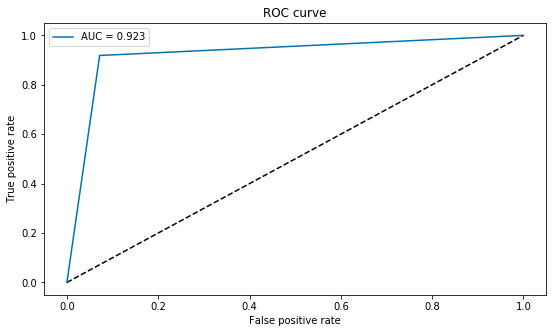

In [22]:
plt.style.use("seaborn-colorblind")
plt.figure(figsize=(9,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("Model_Binary_Transfer_Learning_VGG19_10_epochs_ROC.jpg")

## Conclusion

We have been able to build a model that accurately classifies both normal and pneumonia Chest-X-Rays given a jpg image. Althought the model slightly overfits (train-acc: 94.19 , val-acc: 92.70 , test-acc: 92.35) we believe that if the model performs well this difference is affordable. You can check model performance in real life in the following [notebook](https://github.com/EiroaMD/final_project_IH_pneumonia).